<a href="https://colab.research.google.com/github/Tien84/BitcoinPrediction/blob/master/demoCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [65]:
from google.colab import drive
drive.mount('/content/driver')

Drive already mounted at /content/driver; to attempt to forcibly remount, call drive.mount("/content/driver", force_remount=True).


In [93]:
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, LSTM, Flatten, TimeDistributed, ConvLSTM2D
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D


import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
%matplotlib inline

In [95]:
hist = pd.read_csv('/content/driver/My Drive/DataSet/DataBitcoin.csv')
hist = hist.set_index('Date')
hist.index = pd.to_datetime(hist.index)
target_col = 'Adj Close'

In [96]:
hist.head(5)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-11-03,361.872986,417.899994,357.647003,403.416992,403.416992,206162000
2015-11-04,403.664001,495.562012,380.548004,411.562988,411.562988,263900000
2015-11-05,408.076996,447.561005,374.580994,386.354004,386.354004,151824992
2015-11-06,388.046997,395.835999,354.024994,374.470001,374.470001,122687000
2015-11-07,374.269012,390.585999,372.433014,386.481995,386.481995,56625100


In [97]:
hist.tail(5)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-10-30,20817.982422,20917.005859,20547.462891,20635.603516,20635.603516,31486345556
2022-10-31,20633.695313,20795.320313,20287.458984,20495.773438,20495.773438,45668466815
2022-11-01,20494.898438,20647.289063,20359.845703,20485.273438,20485.273438,39819303159
2022-11-02,20482.958984,20742.810547,20087.134766,20159.503906,20159.503906,55552169483
2022-11-03,20158.783203,20335.416016,20148.492188,20335.416016,20335.416016,56120430592


In [98]:
def train_test_split(df, test_size=0.2):
    split_row = len(df) - int(test_size * len(df))
    train_data = df.iloc[:split_row]
    test_data = df.iloc[split_row:]
    return train_data, test_data

In [99]:
def line_plot(line1, line2, label1=None, label2=None, title='', lw=2):
    fig, ax = plt.subplots(1, figsize=(13, 7))
    ax.plot(line1, label=label1, linewidth=lw)
    ax.plot(line2, label=label2, linewidth=lw)
    ax.set_ylabel('price [USD]', fontsize=14)
    ax.set_title(title, fontsize=16)
    ax.legend(loc='best', fontsize=16);

In [100]:
train, test = train_test_split(hist, test_size=0.2)

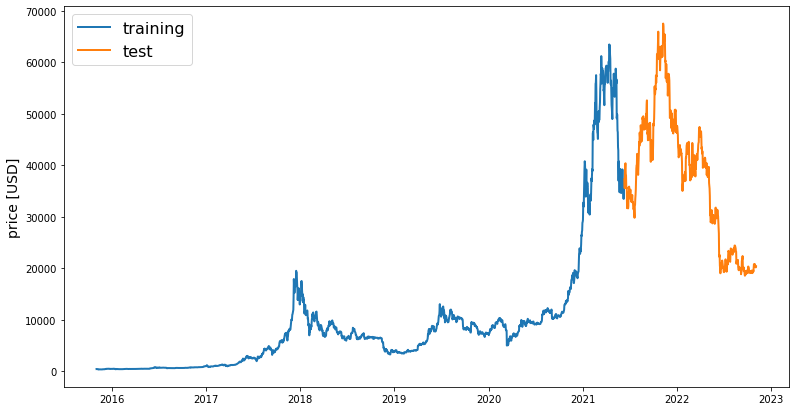

In [101]:
line_plot(train[target_col], test[target_col], 'training', 'test', title='')

In [102]:
def normalise_zero_base(df):
    return df / df.iloc[0] - 1

def normalise_min_max(df):
    return (df - df.min()) / (df.max() - df.min())

In [103]:
def extract_window_data(df, window_len=5, zero_base=True):
    window_data = []
    for idx in range(len(df) - window_len):
        tmp = df[idx: (idx + window_len)].copy()
        if zero_base:
            tmp = normalise_zero_base(tmp)
        window_data.append(tmp.values)
    return np.array(window_data)

In [104]:
def prepare_data(df, target_col, window_len=10, zero_base=True, test_size=0.2):
    train_data, test_data = train_test_split(df, test_size=test_size)
    X_train = extract_window_data(train_data, window_len, zero_base)
    X_test = extract_window_data(test_data, window_len, zero_base)
    y_train = train_data[target_col][window_len:].values
    y_test = test_data[target_col][window_len:].values
    if zero_base:
        y_train = y_train / train_data[target_col][:-window_len].values - 1
        y_test = y_test / test_data[target_col][:-window_len].values - 1

    return train_data, test_data, X_train, X_test, y_train, y_test

In [105]:
np.random.seed(42)
window_len = 5
test_size = 0.2
zero_base = True
epochs = 50
batch_size = 30

In [106]:
train, test, X_train, X_test, y_train, y_test = prepare_data(
    hist, target_col, window_len=window_len, zero_base=zero_base, test_size=test_size)

In [107]:
def build_cnn_model(input_data):
    # define model
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(input_data.shape[1], input_data.shape[2])))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(50, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

In [108]:
model = build_cnn_model(X_train)
history = model.fit(
    X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1, shuffle=True)

Epoch 1/50
69/69 [==============================] - 1s 2ms/step - loss: 0.0046
Epoch 2/50
69/69 [==============================] - 0s 2ms/step - loss: 0.0028
Epoch 3/50
69/69 [==============================] - 0s 2ms/step - loss: 0.0024
Epoch 4/50
69/69 [==============================] - 0s 2ms/step - loss: 0.0025
Epoch 5/50
69/69 [==============================] - 0s 2ms/step - loss: 0.0021
Epoch 6/50
69/69 [==============================] - 0s 2ms/step - loss: 0.0021
Epoch 7/50
69/69 [==============================] - 0s 2ms/step - loss: 0.0021
Epoch 8/50
69/69 [==============================] - 0s 2ms/step - loss: 0.0020
Epoch 9/50
69/69 [==============================] - 0s 2ms/step - loss: 0.0020
Epoch 10/50
69/69 [==============================] - 0s 2ms/step - loss: 0.0021
Epoch 11/50
69/69 [==============================] - 0s 2ms/step - loss: 0.0020
Epoch 12/50
69/69 [==============================] - 0s 2ms/step - loss: 0.0019
Epoch 13/50
69/69 [==============================

In [109]:
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 4, 64)             832       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 2, 64)            0         
 )                                                               
                                                                 
 flatten_2 (Flatten)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 50)                6450      
                                                                 
 dropout_2 (Dropout)         (None, 50)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 51        
                                                      

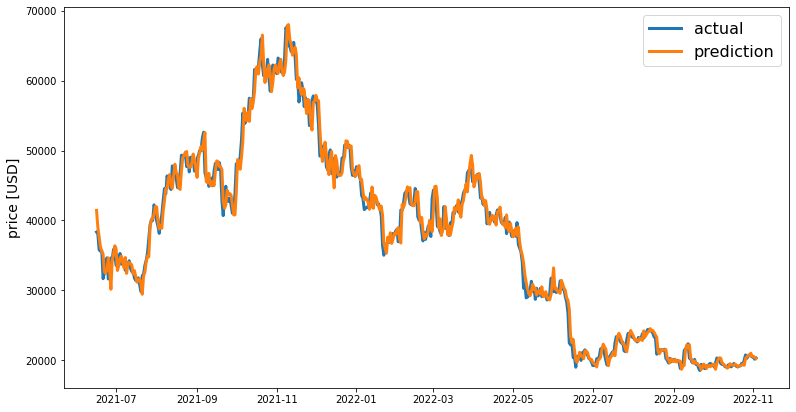

In [111]:
preds = test[target_col].values[:-window_len] * (preds + 1)
preds = pd.Series(index=targets.index, data=preds)
line_plot(targets, preds, 'actual', 'prediction', lw=3)

In [110]:
targets = test[target_col][window_len:]
preds = model.predict(X_test).squeeze()
print("RMSE: " + str(mean_squared_error(y_test, preds, squared=False)))
print("MAPE: " + str(mean_absolute_percentage_error(y_test, preds)))

16/16 [==============================] - 0s 2ms/step
RMSE: 0.036762359879942294
MAPE: 2.7649373452108037
